# MRCNN Model

### Introduction

In our project, we trained a Mask R-CNN model to segment the head, flippers, and carapace  of sea turtles. Based on the results, we achieved promising outcomes with high mean Intersection over Union (mIoU) scores for each class: 0.9307 for the turtle, 0.8941 for the flippers, and 0.9102 for the head. However, we noticed some cases where certain parts of the turtle are not recognized. In this analysis, we will discuss our approach, interpret the results, analyze possible reasons for the misclassifications, and suggest improvements to enhance our model's performance.


### Training Setup

We divided our dataset, which consists of 2,400 images in the training set, 1,200 in the validation set, and 1,000 in the test set, into distinct splits to ensure that the model is trained and evaluated on separate data. For data transformations, we applied augmentation techniques during training, such as random horizontal flips, to increase data diversity. Validation and test transformations likely include only basic preprocessing, such as converting images to tensors, to keep them consistent with the model's evaluation phase.

Our model architecture is a Mask R-CNN with a ResNet-50 backbone combined with a Feature Pyramid Network (FPN) for better multi-scale feature representation. We defined four classes (background, turtle, flipper, and head) to support detailed segmentation. The training process used stochastic gradient descent (SGD) as the optimizer, with a learning rate of 0.005, momentum of 0.9, and weight decay of 0.0005. A StepLR scheduler was used to decrease the learning rate every three epochs by a factor of 0.1. The model was trained for at least eight epochs, after which we observed a final validation loss of 0.3233, indicating effective but not flawless learning.



### Results Analysis

Our mIoU scores: 0.9307 for the turtle, 0.8941 for the flippers, and 0.9102 for the head, show that the model performs well across all three segments, with slightly lower performance on the flippers and head. While these high mIoU scores indicate that the model successfully learned the segmentation tasks, we noticed cases where specific parts of the turtle went unrecognized, suggesting there may be underlying limitations in the model or dataset that we can address.

Despite the high mIoU scores, we observed instances where certain parts of the turtle were not detected. One potential reason for this could be data imbalance. If some classes, such as the flippers or head, appear less frequently in the training data, the model might not learn to recognize them effectively. The slightly lower mIoU for flippers (0.8941) and head (0.9102) could indicate underrepresentation or that these parts are more challenging to segment due to their size and shape.

Another factor could be variability in turtle poses and environmental conditions. Different poses could cause certain parts, like the flippers or head, to be occluded, making them harder for the model to detect. Moreover, complex backgrounds or lighting conditions might introduce noise, resulting in false negatives.

The model's architecture and training strategy may also contribute to these issues. If the model is overfitting, it may perform well on the training data but fail to generalize on unseen cases. Additionally, if the model's capacity is insufficient, it might not capture all variations present in the data. Observing the validation loss trend and ensuring there’s no significant gap between training and validation performance can help us gauge if overfitting is an issue.

Optimization settings, like the learning rate and scheduler, could also impact the model's performance. A suboptimal learning rate schedule may prevent the model from converging on a better solution, and reducing the learning rate too quickly could limit improvement.


### Conclusion

Our model has achieved impressive mIoU scores, indicating strong performance in segmenting sea turtles. However, the presence of misclassified instances suggests room for improvement. By addressing potential issues related to data imbalance, model capacity, and small object detection, we can enhance our model's ability to recognize all parts of the turtle accurately.

Implementing these recommended strategies will likely lead to better generalization and robustness. Iterative experimentation and tracking the effects of each change will allow us to refine our approach further and achieve more reliable segmentation results.



## Coding

In [ ]:
# Install required libraries
!pip install torch torchvision pycocotools

In [ ]:
%cd drive/MyDrive/COMP9517
!pwd

[Errno 2] No such file or directory: 'drive/MyDrive/COMP9517'
/content
/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
import cv2
import pandas as pd
import numpy as np
import torchvision
import os
import random
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt

# Custom Transforms
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class ToTensor(object):
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target

class RandomHorizontalFlip(object):
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            image = F.hflip(image)
            width = image.shape[-1]

            if 'boxes' in target:
                boxes = target['boxes']
                boxes[:, [0, 2]] = width - boxes[:, [2, 0]]
                target['boxes'] = boxes

            if 'masks' in target:
                target['masks'] = target['masks'].flip(-1)
        return image, target

# Dataset class
class SeaTurtleDataset(Dataset):
    def __init__(self, img_dir, ann_file, split='train', transforms=None, limit_data=None):
        self.coco = COCO(ann_file)
        self.img_dir = img_dir
        self.transforms = transforms

        # Load metadata file
        metadata = pd.read_csv('turtles-data/data/metadata_splits.csv')

        self.img_ids = metadata[metadata['split_open'] == split]['id'].tolist()

        if limit_data is not None:
            self.img_ids = self.img_ids[:limit_data]

        valid_img_ids = []
        for img_id in self.img_ids:
            img_info = self.coco.loadImgs(img_id)[0]
            img_path = os.path.join(self.img_dir, img_info['file_name'])
            if os.path.exists(img_path):
                valid_img_ids.append(img_id)
            else:
                print(f"Image not found and will be skipped: {img_path}")
        self.img_ids = valid_img_ids

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'])

        # Load image
        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img = F.to_pil_image(img)

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        target = {}
        boxes = []
        labels = []
        masks = []
        areas = []
        iscrowd = []

        for ann in anns:
            x, y, width, height = ann['bbox']
            boxes.append([x, y, x + width, y + height])
            labels.append(ann['category_id'])
            ann_mask = self.coco.annToMask(ann)
            masks.append(ann_mask)
            areas.append(ann['area'])
            iscrowd.append(ann.get('iscrowd', 0))

        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.tensor([], dtype=torch.int64)
            masks = torch.zeros((0, img_info['height'], img_info['width']), dtype=torch.uint8)
            areas = torch.tensor([], dtype=torch.float32)
            iscrowd = torch.tensor([], dtype=torch.int64)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            masks = torch.stack([torch.as_tensor(m, dtype=torch.uint8) for m in masks])
            areas = torch.as_tensor(areas, dtype=torch.float32)
            iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64)

        target['boxes'] = boxes
        target['labels'] = labels
        target['masks'] = masks
        target['image_id'] = torch.tensor([img_id])
        target['area'] = areas
        target['iscrowd'] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target


In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# Load an instance segmentation model
def get_model(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

    hidden_layer = 256

    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask, hidden_layer, num_classes)

    return model

num_classes = 4  # Background + turtle + flipper + head
model = get_model(num_classes)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import torch
import torch.utils.data
from torch.utils.data import DataLoader

def get_transform(train):
    transforms = []
    transforms.append(ToTensor())
    if train:
        transforms.append(RandomHorizontalFlip(0.5))
    return Compose(transforms)

# path
image_root = 'turtles-data/data'
annotation_file = 'turtles-data/data/annotations.json'

train_transforms = get_transform(train=True)
valid_transforms = get_transform(train=False)
test_transforms = get_transform(train=False)

# Create datasets
train_dataset = SeaTurtleDataset(image_root, annotation_file, split='train', transforms=train_transforms, limit_data=2400)
valid_dataset = SeaTurtleDataset(image_root, annotation_file, split='valid', transforms=valid_transforms, limit_data=1200)
test_dataset = SeaTurtleDataset(image_root, annotation_file, split='test', transforms=test_transforms, limit_data=1000)

# Define data loaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
valid_dataloader = DataLoader(valid_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)


loading annotations into memory...
Done (t=9.89s)
creating index...
index created!
loading annotations into memory...
Done (t=4.58s)
creating index...
index created!
loading annotations into memory...
Done (t=4.84s)
creating index...
index created!


In [ ]:
def compute_validation_loss(model, data_loader, device):
    was_training = model.training

    model.train()
    val_loss = 0
    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            # Compute total loss
            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()
    val_loss /= len(data_loader)

    if not was_training:
        model.eval()

    return val_loss


In [ ]:
num_epochs = 8

for epoch in range(num_epochs):
    model.train()
    i = 0
    for images, targets in train_dataloader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)

        # Compute total loss
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass and optimization
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        i += 1
        if i % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(train_dataloader)}], Loss: {losses.item():.4f}")

    # Update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    # Compute validation loss
    val_loss = compute_validation_loss(model, valid_dataloader, device)
    print(f"Validation Loss after Epoch {epoch+1}: {val_loss:.4f}")


Epoch [1/8], Step [10/300], Loss: 0.4347
Epoch [1/8], Step [20/300], Loss: 0.3482
Epoch [1/8], Step [30/300], Loss: 0.3710
Epoch [1/8], Step [40/300], Loss: 0.4986
Epoch [1/8], Step [50/300], Loss: 0.3555
Epoch [1/8], Step [60/300], Loss: 0.3537
Epoch [1/8], Step [70/300], Loss: 0.3892
Epoch [1/8], Step [80/300], Loss: 0.3559
Epoch [1/8], Step [90/300], Loss: 0.2949
Epoch [1/8], Step [100/300], Loss: 0.2697
Epoch [1/8], Step [110/300], Loss: 0.3562
Epoch [1/8], Step [120/300], Loss: 0.3590
Epoch [1/8], Step [130/300], Loss: 0.3383
Epoch [1/8], Step [140/300], Loss: 0.2995
Epoch [1/8], Step [150/300], Loss: 0.3712
Epoch [1/8], Step [160/300], Loss: 0.2902
Epoch [1/8], Step [170/300], Loss: 0.2634
Epoch [1/8], Step [180/300], Loss: 0.3221
Epoch [1/8], Step [190/300], Loss: 0.2842
Epoch [1/8], Step [200/300], Loss: 0.3498
Epoch [1/8], Step [210/300], Loss: 0.2717
Epoch [1/8], Step [220/300], Loss: 0.3178
Epoch [1/8], Step [230/300], Loss: 0.3508
Epoch [1/8], Step [240/300], Loss: 0.2537
E

In [ ]:
# Save the model
torch.save(model.state_dict(), 'maskrcnn_seaturtle.pth')


In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = 4  # Background + turtle + flipper + head
model = get_model(num_classes)
model.load_state_dict(torch.load('maskrcnn_seaturtle.pth', map_location=device))
model.to(device)

# IoU
def compute_iou(mask1, mask2):
    """Compute the IoU between two binary masks."""
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    if union == 0:
        return 0.0
    else:
        return intersection / union

# Visualization
def visualize_predictions(model, dataset, device, num_images, score_threshold=0.5):
    model.eval()
    ious_per_class = {1: [], 2: [], 3: []}
    class_names = ['Background', 'Turtle', 'Flipper', 'Head']

    specific_images = [5, 14, 2, 29]
    good_examples = [5, 14]
    bad_examples = [2, 29]

    with torch.no_grad():
        for idx in specific_images:
            img, target = dataset[idx]
            img = img.to(device)
            output = model([img])[0]

            img_cpu = img.cpu().permute(1, 2, 0).numpy()
            img_cpu = (img_cpu * 255).astype(np.uint8)

            gt_masks = target['masks'].numpy()
            gt_labels = target['labels'].numpy()

            pred_masks = output['masks'].cpu().numpy()
            pred_labels = output['labels'].cpu().numpy()
            pred_scores = output['scores'].cpu().numpy()

            pred_masks = pred_masks >= 0.5

            # Colors for visualization
            colors = np.array([
                [0, 0, 0],        # Background - black
                [255, 0, 0],      # Turtle - red
                [0, 255, 0],      # Flipper - green
                [0, 0, 255],      # Head - blue
            ])

            # Ground truth overlay
            gt_overlay = img_cpu.copy()
            for i in range(len(gt_masks)):
                mask = gt_masks[i]
                label = gt_labels[i]
                color = colors[label % len(colors)]
                gt_overlay[mask == 1] = (gt_overlay[mask == 1] * 0.5 + color * 0.5).astype(np.uint8)

            # Predicted overlay with IoU scores
            pred_overlay = img_cpu.copy()
            fig, ax = plt.subplots(1, 3, figsize=(20, 8))
            ax[0].imshow(img_cpu)
            ax[0].set_title('Original Image')
            ax[0].axis('off')

            for i in range(len(pred_masks)):
                if pred_scores[i] >= score_threshold:
                    mask = pred_masks[i, 0]
                    label = pred_labels[i]
                    color = colors[label % len(colors)]
                    pred_overlay[mask == 1] = (pred_overlay[mask == 1] * 0.5 + color * 0.5).astype(np.uint8)

                    ious = []
                    for j in range(len(gt_masks)):
                        if gt_labels[j] == label:
                            gt_mask = gt_masks[j]
                            iou = compute_iou(mask, gt_mask)
                            ious.append(iou)
                        else:
                            ious.append(0)
                    if ious:
                        best_iou = max(ious)
                        ious_per_class[label].append(best_iou)
                    else:
                        best_iou = 0.0

                    y_indices, x_indices = np.where(mask == 1)
                    if len(y_indices) > 0 and len(x_indices) > 0:
                        y = y_indices[0]
                        x = x_indices[0]
                        ax[2].text(x, y, f'IoU: {best_iou:.2f}', color='white', fontsize=8, backgroundcolor="black")

            # Plotting
            ax[1].imshow(gt_overlay)
            ax[1].set_title('Ground Truth Masks')
            ax[1].axis('off')

            if idx in good_examples:
                example_type = 'Good Example'
            elif idx in bad_examples:
                example_type = 'Bad Example'
            else:
                example_type = 'Example'

            ax[2].imshow(pred_overlay)
            ax[2].set_title(f'Predicted Masks with IoU ({example_type, idx})')
            ax[2].axis('off')

            plt.show()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-35-15db13c1b24f>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-m

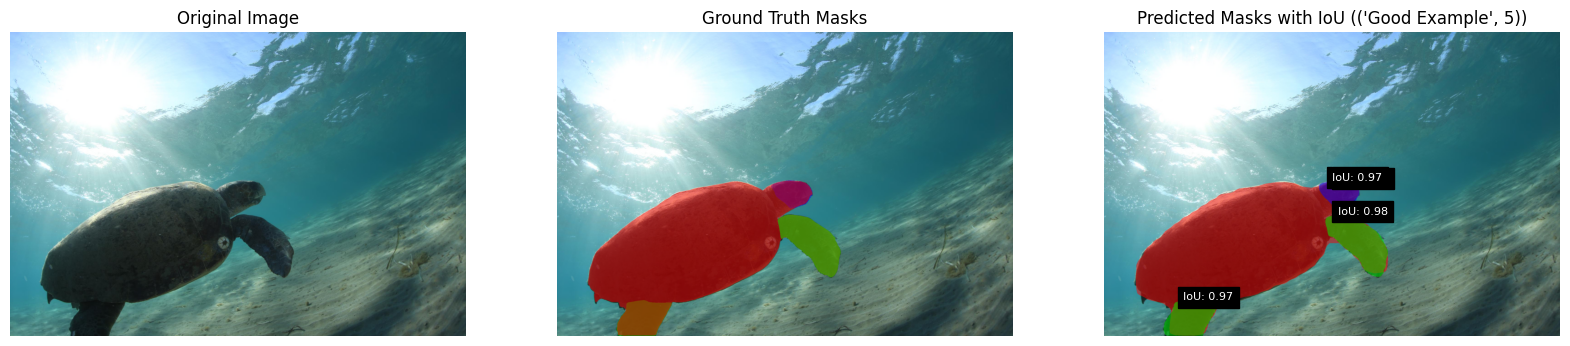

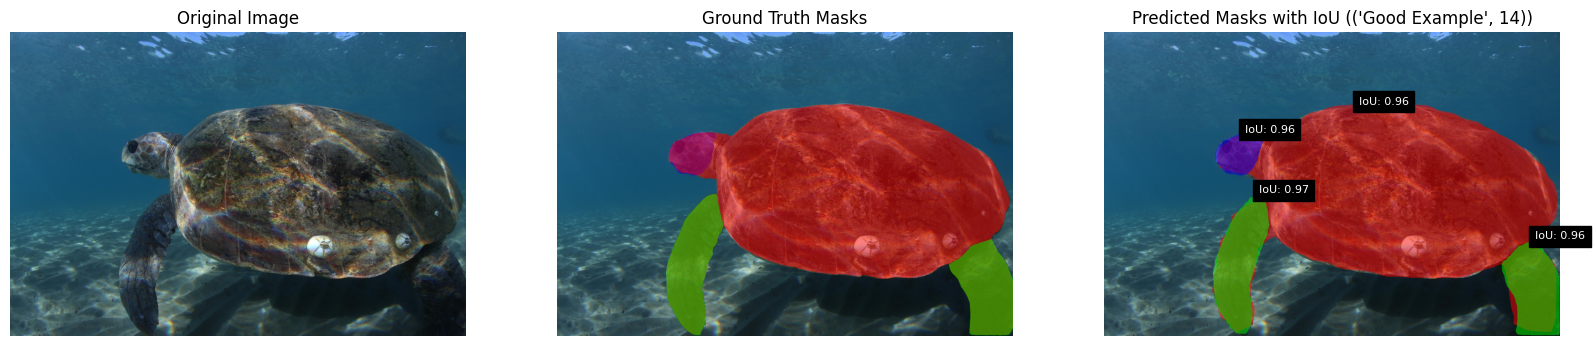

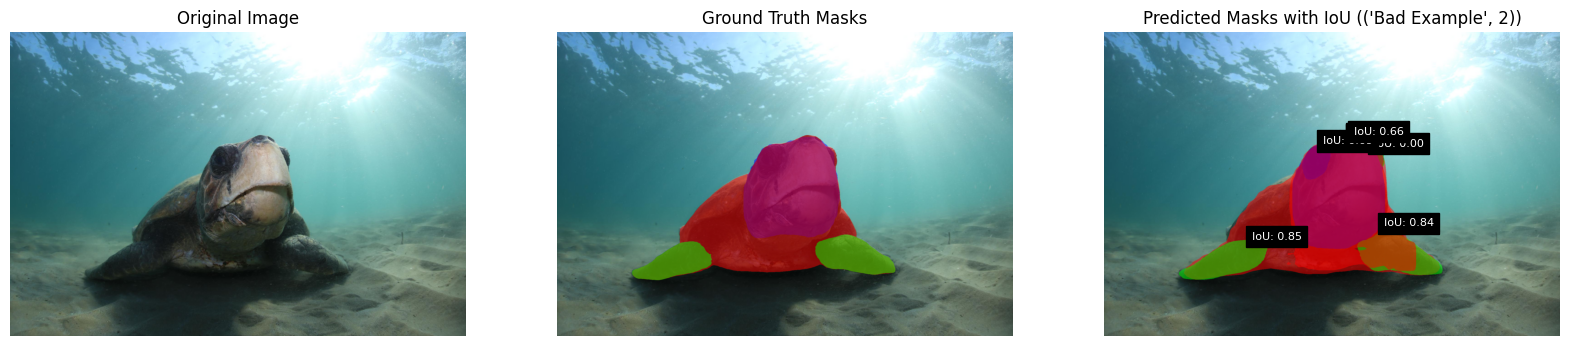

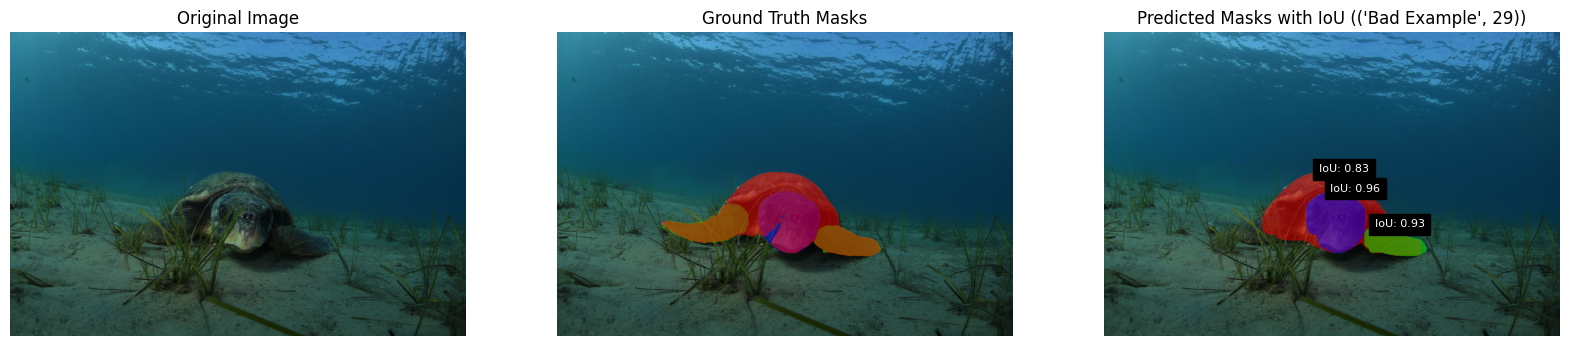

In [ ]:
visualize_predictions(model, test_dataset, device, num_images=4)


In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader

# Visualization and mIoU computation
def compute_and_visualize_miou(model, dataset, device, num_images=None, score_threshold=0.5):
    model.eval()
    ious_per_class = {1: [], 2: [], 3: []}
    class_names = ['Background', 'Turtle', 'Flipper', 'Head']

    num_images = num_images if num_images is not None else len(dataset)

    with torch.no_grad():
        for idx in range(num_images):
            img, target = dataset[idx]
            img = img.to(device)
            output = model([img])[0]

            img_cpu = img.cpu().permute(1, 2, 0).numpy()
            img_cpu = (img_cpu * 255).astype(np.uint8)

            gt_masks = target['masks'].numpy()
            gt_labels = target['labels'].numpy()

            pred_masks = output['masks'].cpu().numpy()
            pred_labels = output['labels'].cpu().numpy()
            pred_scores = output['scores'].cpu().numpy()

            pred_masks = pred_masks >= 0.5

            # Collect IoU scores per class
            for i in range(len(pred_masks)):
                if pred_scores[i] >= score_threshold:
                    pred_mask = pred_masks[i, 0]
                    pred_label = pred_labels[i]

                    max_iou = 0.0
                    for j in range(len(gt_masks)):
                        if gt_labels[j] == pred_label:
                            gt_mask = gt_masks[j]
                            iou = compute_iou(pred_mask, gt_mask)
                            if not np.isnan(iou) and iou > max_iou:
                                max_iou = iou
                    if max_iou > 0:
                        ious_per_class[pred_label].append(max_iou)

    # Compute and print mIoU per class
    for idx in range(1, len(class_names)):
        ious = ious_per_class.get(idx, [])
        mean_iou = np.mean(ious) if len(ious) > 0 else np.nan
        print(f'{class_names[idx]} mIoU: {mean_iou:.4f}')

compute_and_visualize_miou(model, test_dataset, device, num_images=1000, score_threshold=0.5)


Turtle mIoU: 0.9307
Flipper mIoU: 0.8941
Head mIoU: 0.9102
